# Tải thư viện

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation

from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import pandas_datareader.data as web

# Lấy và xử lý dữ liệu

In [2]:
raw_data = web.DataReader('ACAD',data_source="yahoo",start="01/01/2015",end="01/01/2019").dropna()

In [3]:
raw_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1007.000000,1007.000000,1007.000000,1007.000000,1.007000e+03,1007.000000
mean,30.494777,29.049672,29.804359,29.761529,2.128100e+06,29.761529
std,8.060953,7.871202,7.965520,7.991366,1.986227e+06,7.991366
min,13.300000,12.770000,12.800000,13.030000,3.569000e+05,13.030000
25%,24.559999,22.715000,23.790000,23.675000,1.181750e+06,23.675000
50%,32.049999,30.500000,31.280001,31.200001,1.643600e+06,31.200001
75%,36.320002,34.625000,35.484999,35.559999,2.322450e+06,35.559999
max,51.990002,49.700001,50.759998,50.099998,2.386240e+07,50.099998


(1007, 1)             Close
Date             
2014-12-31  31.75
2015-01-02  31.15
2015-01-05  31.10
2015-01-06  30.98
2015-01-07  32.16


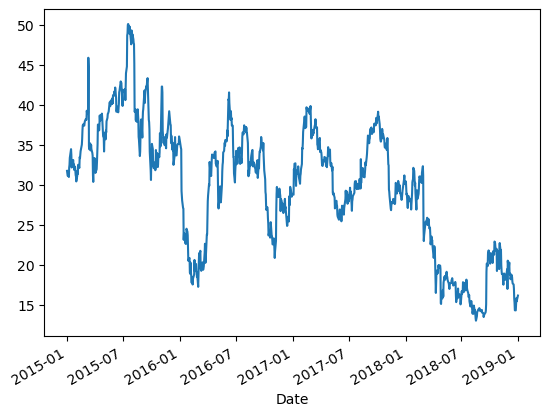

In [4]:
df = raw_data.dropna()
df = df[['Open', 'High', 'Low', 'Close']]
df = df[['Close']]
first_price = df.Close.iloc[0]
print(df.shape, df.head())

df.Close.plot()
def create_ds(ds, look_back):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back-1): 
        data = ds[i:(i+look_back), 0]      
        dataX.append(data)
        dataY.append(ds[i + look_back, 0]) 
    return np.array(dataX), np.array(dataY)

ds = df.values
ds = ds.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

## Tách ds thành các tập train và test

In [5]:
#  Chia tập train và tập test theo ty lệ 8 - 2
train_size = int(len(ds) * 0.85)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]

In [6]:
look_back = 20
trainX, trainY = create_ds(train, look_back)
testX, testY = create_ds(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)

(834, 20, 1)


## Xây dựng model

In [7]:
model = Sequential()
model.add(Dense(158, input_shape = (trainX.shape[1],trainX.shape[2]), activation = 'relu', kernel_initializer='uniform'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1, activation = 'relu'))

In [8]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer= opt, loss = "mean_squared_error")
start = time.time()
# print(trainX.shape)
history = model.fit(trainX, trainY, epochs = 50 , batch_size= 32, shuffle=True ,validation_split = 0.15)
print('Thời gian huấn luyện: ', time.time() - start)
model.summary()

(834, 20, 1)
Epoch 1/50
23/23 [==============================] - 1s 9ms/step - loss: 0.2941 - val_loss: 0.0950
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2130 - val_loss: 0.0566
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1317 - val_loss: 0.0247
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0644 - val_loss: 0.0087
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0099
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0132 - val_loss: 0.0155
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0176
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0178
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0171
Epoch 10/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0164
Epoch 

## Sử dụng model để dự đoán kết quả

In [9]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Chỉ số tập train: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Chỉ số tập test: %.3f RMSE' % (testScore))

5/5 [==============================] - 0s 1ms/step
Chỉ số tập train: 3.009 RMSE
Chỉ số tập test: 3.289 RMSE


## Đồ Thị biểu thị kết quả dự đoán

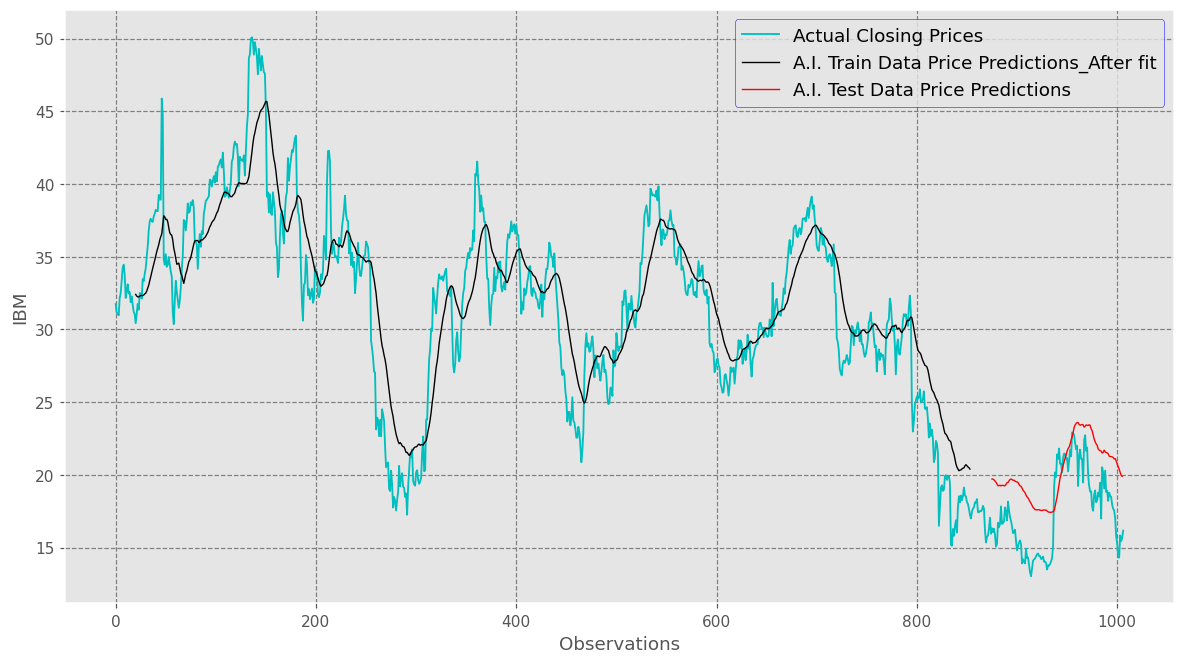

In [10]:
trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

plt.style.use('ggplot')
plt.figure(figsize=(13,7), dpi=110)
plt.grid(color='grey', linestyle='dashed')
plt.xlabel('Observations')
plt.ylabel('IBM',rotation=90)
plt.plot(scaler.inverse_transform(ds), label = 'Actual Closing Prices', linewidth = 1.2, color = 'c')
plt.plot(trainPredictPlot, label = 'A.I. Train Data Price Predictions_After fit', linewidth = 0.9, color = 'k')
plt.plot(testPredictPlot, label = 'A.I. Test Data Price Predictions', linewidth = 0.9, color = 'r')
legend = plt.legend(fontsize = 12,frameon = True)
legend.get_frame().set_edgecolor('b')
legend.get_frame().set_linewidth(0.4)

plt.show()

In [11]:
# model.save('ffnn_model.h5')

In [12]:
# ds = [[20],[40,20],[20,30,40]]
# for i, nodes in enumerate(ds):
#     print(i, nodes)

In [14]:
print(testX.shape)

(131, 20, 1)
